### Run basic `scanpy` QC and doublet detection with `scrublet` for **PBMC Tuberculosis** _Nathan et al 2021_

- **Developed by**: Carlos Talavera-López PhD
- **Modified by**: Mairi McClean
- **Computational Health Centre - Helmholtz Munich**
- ORIGINAL: v221101; MODIFIED: v221117

### Load required modules

In [16]:
import anndata
import logging
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sb
import scrublet as scr
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import rcParams

In [17]:
sc.settings.verbosity = 3
sc.logging.print_versions()
sc.settings.set_figure_params(dpi = 160, color_map = 'RdPu', dpi_save = 180, vector_friendly = True, format = 'svg')

-----
anndata     0.8.0
scanpy      1.9.1
-----
PIL                 9.2.0
appnope             0.1.3
asttokens           NA
backcall            0.2.0
beta_ufunc          NA
binom_ufunc         NA
cffi                1.15.1
colorama            0.4.6
cycler              0.10.0
cython_runtime      NA
dateutil            2.8.2
debugpy             1.6.3
decorator           5.1.1
entrypoints         0.4
executing           1.1.1
google              NA
h5py                3.6.0
hypergeom_ufunc     NA
ipykernel           6.16.2
ipywidgets          8.0.2
jedi                0.18.1
joblib              1.2.0
kiwisolver          1.4.4
llvmlite            0.39.1
matplotlib          3.6.1
matplotlib_inline   0.1.6
mpl_toolkits        NA
natsort             8.2.0
nbinom_ufunc        NA
ncf_ufunc           NA
numba               0.56.3
numexpr             2.8.1
numpy               1.23.4
packaging           21.3
pandas              1.5.1
parso               0.8.3
pexpect             4.8.0
pickleshare  

### Read datasets

In [18]:
adata = sc.read_h5ad('/Users/mairi.mcclean/github/data/tb_pbmc_datasets/Lung_TB_T_Cells_CITESEQ_RNA.h5ad')
adata

AnnData object with n_obs × n_vars = 500089 × 33538
    obs: 'cell_id', 'nUMI', 'nGene', 'percent_mito', 'batch', 'TB_status', 'UMAP_1', 'UMAP_2', 'cluster_name', 'cluster_ids', 'donor'

In [19]:
adata.obs['donor'].value_counts()

TB6692076    5487
TB6361266    5403
TB0763419    4489
TB5758296    4225
TB6448199    4224
             ... 
TB8805781     234
TB0414005     234
TB8797251     202
TB5742418     114
TB4817029      72
Name: donor, Length: 259, dtype: int64

In [20]:
adata.var_names_make_unique()
sample_object = adata.copy()
sample_object

AnnData object with n_obs × n_vars = 500089 × 33538
    obs: 'cell_id', 'nUMI', 'nGene', 'percent_mito', 'batch', 'TB_status', 'UMAP_1', 'UMAP_2', 'cluster_name', 'cluster_ids', 'donor'

### Filter cells with less than 200 genes

In [21]:
sc.pp.filter_cells(sample_object, min_genes = 200)
print(sample_object.n_obs, sample_object.n_vars)

500089 33538


In [22]:
sample_object.shape

(500089, 33538)

In [23]:
sample_object.var

Empty DataFrame
Columns: []
Index: [MIR1302-2HG, FAM138A, OR4F5, AL627309.1, AL627309.3, AL627309.2, AL627309.4, AL732372.1, OR4F29, AC114498.1, OR4F16, AL669831.2, AL669831.5, FAM87B, LINC00115, FAM41C, AL645608.7, AL645608.3, AL645608.5, AL645608.1, SAMD11, NOC2L, KLHL17, PLEKHN1, PERM1, AL645608.8, HES4, ISG15, AL645608.2, AGRN, AL645608.9, RNF223, C1orf159, LINC01342, AL390719.2, TTLL10-AS1, TTLL10, TNFRSF18, TNFRSF4, SDF4, B3GALT6, C1QTNF12, AL162741.1, UBE2J2, LINC01786, SCNN1D, ACAP3, PUSL1, INTS11, CPTP, TAS1R3, DVL1, MXRA8, AURKAIP1, CCNL2, MRPL20, AL391244.3, ANKRD65, AL391244.2, TMEM88B, LINC01770, VWA1, ATAD3C, ATAD3B, ATAD3A, TMEM240, SSU72, AL645728.1, FNDC10, AL691432.2, MIB2, MMP23B, CDK11B, FO704657.1, SLC35E2B, CDK11A, SLC35E2A, NADK, GNB1, AL109917.1, CALML6, TMEM52, CFAP74, AL391845.2, GABRD, AL391845.1, PRKCZ, AL590822.2, PRKCZ-AS1, FAAP20, AL590822.1, SKI, MORN1, RER1, PEX10, PLCH2, AL139246.1, AL139246.4, PANK4, HES5, ...]

[33538 rows x 0 columns]

### Compute QC stats

In [24]:
sample_object.shape

(500089, 33538)

In [25]:
sample_object.var['mt'] = sample_object.var_names.str.startswith('MT-') 
sample_object.var['ribo'] = sample_object.var_names.str.startswith(("RPS","RPL"))
sample_object.var

mt   ribo
MIR1302-2HG  False  False
FAM138A      False  False
OR4F5        False  False
AL627309.1   False  False
AL627309.3   False  False
...            ...    ...
AC233755.2   False  False
AC233755.1   False  False
AC240274.1   False  False
AC213203.1   False  False
FAM231C      False  False

[33538 rows x 2 columns]

In [26]:
sc.pp.calculate_qc_metrics(sample_object, qc_vars = ['mt','ribo'], percent_top = None, log1p = False, inplace = True)

In [27]:
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
# add the total counts per cell as observations-annotation to adata

mito_genes = sample_object.var_names.str.startswith('MT-')
sample_object.obs['percent_mt2'] = np.sum(
    sample_object[:, mito_genes].X, axis = 1).A1 / np.sum(sample_object.X, axis = 1).A1
sample_object.obs['n_counts'] = sample_object.X.sum(axis = 1).A1

In [28]:
sample_object

AnnData object with n_obs × n_vars = 500089 × 33538
    obs: 'cell_id', 'nUMI', 'nGene', 'percent_mito', 'batch', 'TB_status', 'UMAP_1', 'UMAP_2', 'cluster_name', 'cluster_ids', 'donor', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'n_counts'
    var: 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

### Visualise QC metrics

In [29]:
sample_object.var_names

Index(['MIR1302-2HG', 'FAM138A', 'OR4F5', 'AL627309.1', 'AL627309.3',
       'AL627309.2', 'AL627309.4', 'AL732372.1', 'OR4F29', 'AC114498.1',
       ...
       'AC007325.2', 'BX072566.1', 'AL354822.1', 'AC023491.2', 'AC004556.1',
       'AC233755.2', 'AC233755.1', 'AC240274.1', 'AC213203.1', 'FAM231C'],
      dtype='object', length=33538)

In [1]:
sample_object.obs

NameError: name 'sample_object' is not defined

the obs value 'donor' has more than 103 categories. Uniform 'grey' color will be used for all categories.


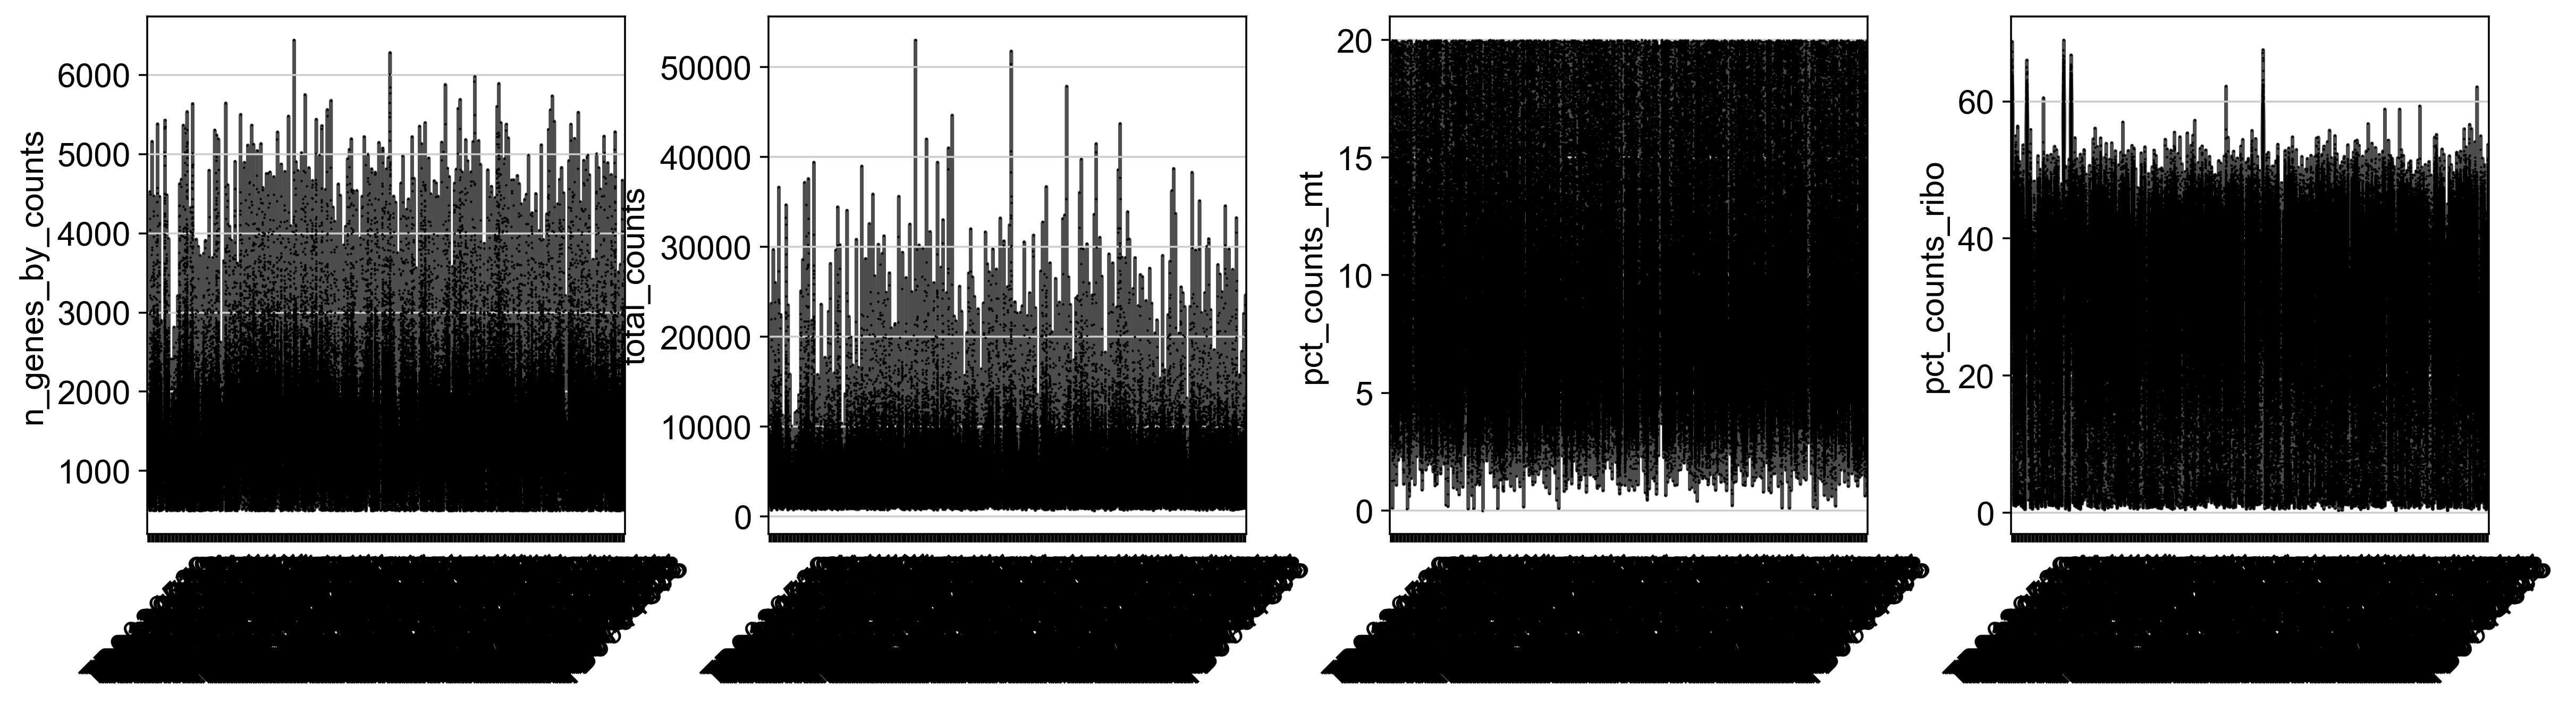

In [30]:
sc.pl.violin(sample_object, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt','pct_counts_ribo'],
             jitter = 0.2, groupby = 'donor', rotation = 45)

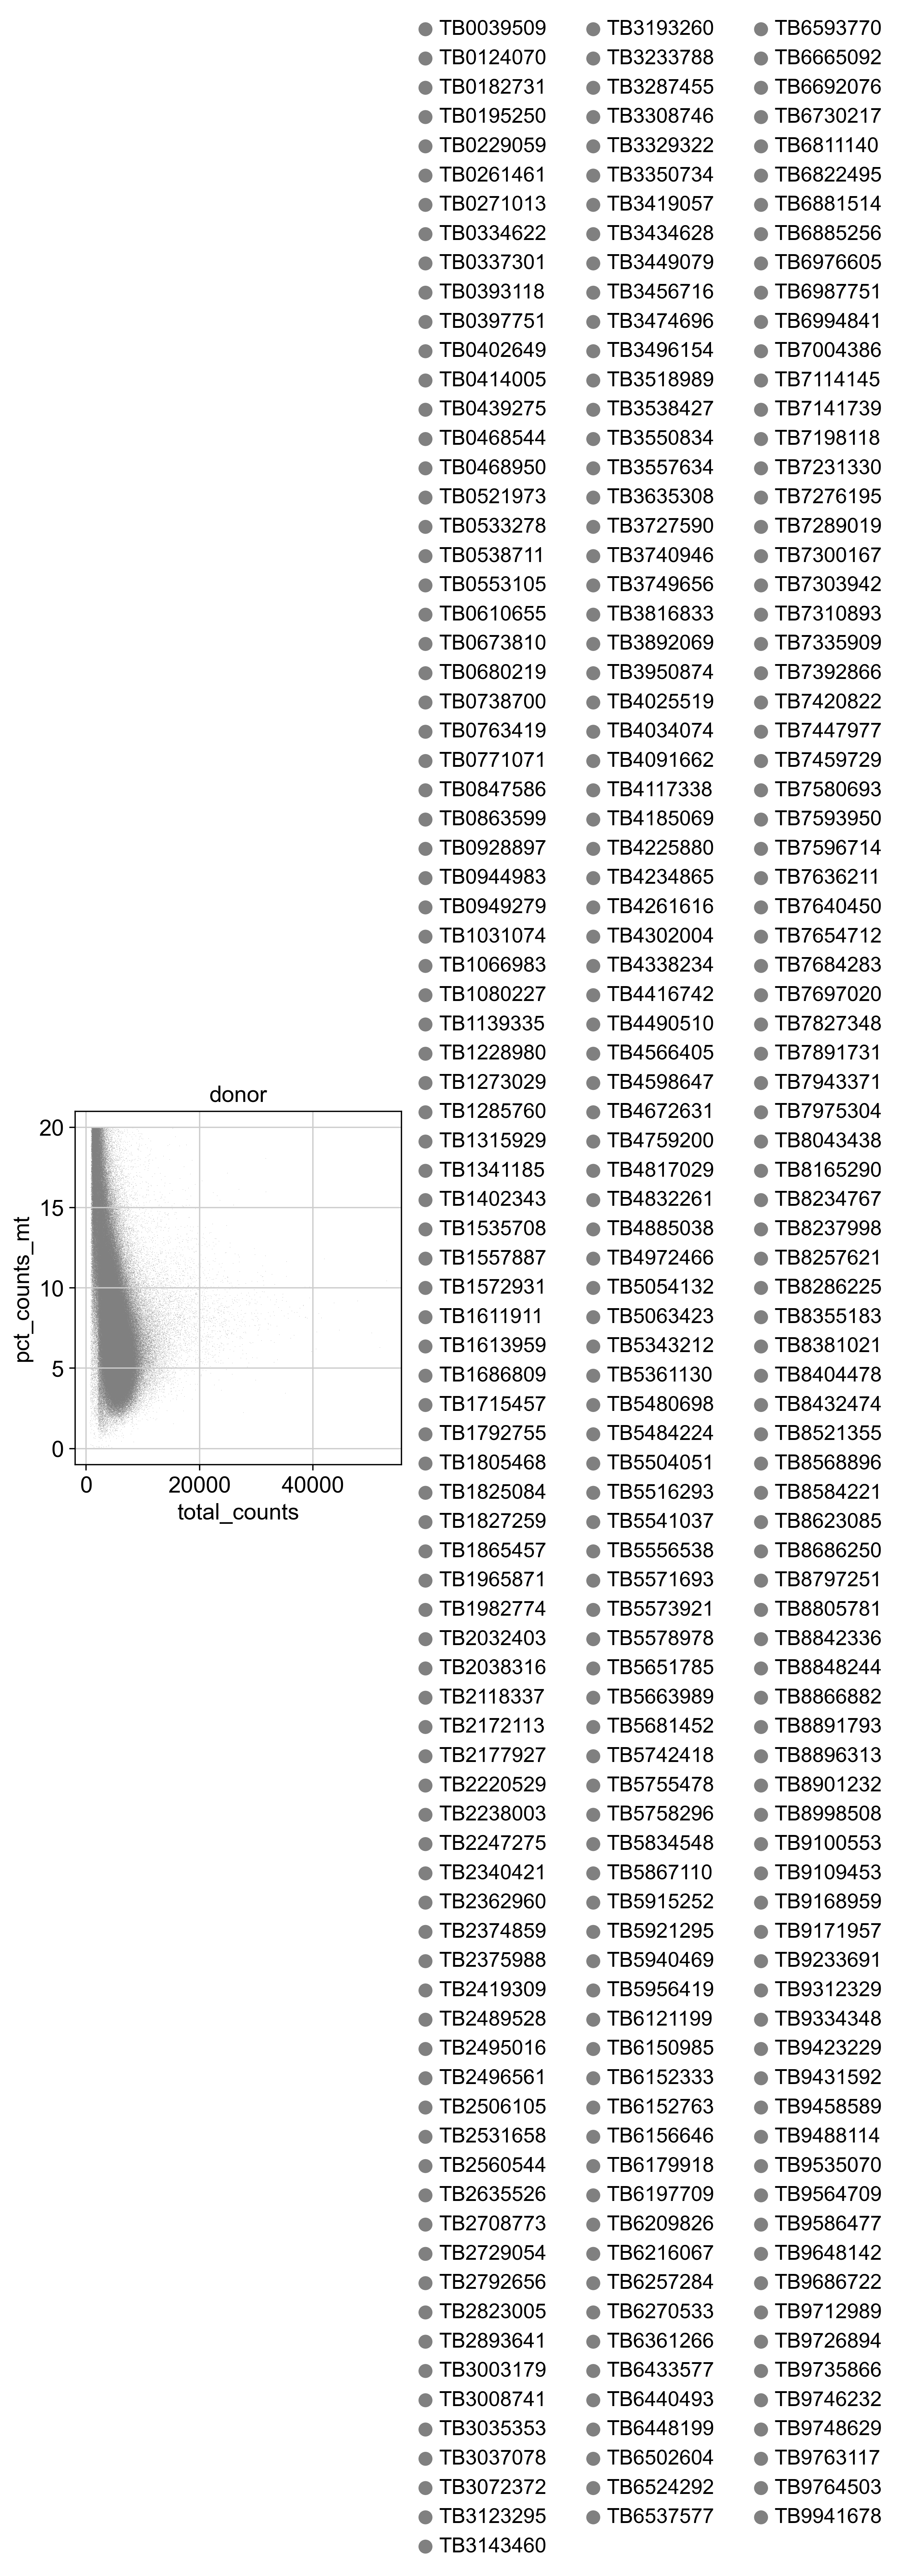

In [31]:
sc.pl.scatter(sample_object, x = 'total_counts', y = 'pct_counts_mt', color = "donor")

### Add sample sex covariate

In [32]:
annot = sc.queries.biomart_annotations(
        "hsapiens",
        ["ensembl_gene_id", "external_gene_name", "start_position", "end_position", "chromosome_name"],
    ).set_index("external_gene_name")

In [33]:
annot.head()

ensembl_gene_id  start_position  end_position  \
external_gene_name                                                  
MT-TF               ENSG00000210049             577           647   
MT-RNR1             ENSG00000211459             648          1601   
MT-TV               ENSG00000210077            1602          1670   
MT-RNR2             ENSG00000210082            1671          3229   
MT-TL1              ENSG00000209082            3230          3304   

                   chromosome_name  
external_gene_name                  
MT-TF                           MT  
MT-RNR1                         MT  
MT-TV                           MT  
MT-RNR2                         MT  
MT-TL1                          MT

In [34]:
chrY_genes = sample_object.var_names.intersection(annot.index[annot.chromosome_name == "Y"])
chrY_genes

Index(['SRY', 'RPS4Y1', 'ZFY', 'ZFY-AS1', 'LINC00278', 'TGIF2LY', 'PCDH11Y',
       'TSPY2', 'LINC00280', 'TTTY1B', 'TTTY2B', 'TTTY21B', 'TTTY7', 'TTTY8B',
       'AMELY', 'TBL1Y', 'TTTY12', 'LINC00279', 'TTTY18', 'TTTY19', 'TTTY11',
       'TTTY20', 'TSPY4', 'TSPY8', 'TSPY3', 'FAM197Y5', 'TSPY1', 'TSPY10',
       'TTTY8', 'TTTY7B', 'TTTY21', 'TTTY2', 'TTTY1', 'TTTY22', 'TTTY23',
       'USP9Y', 'DDX3Y', 'UTY', 'TMSB4Y', 'VCY', 'VCY1B', 'NLGN4Y',
       'NLGN4Y-AS1', 'FAM41AY1', 'FAM224B', 'CDY2B', 'CDY2A', 'FAM224A',
       'FAM41AY2', 'HSFY1', 'TTTY9B', 'HSFY2', 'TTTY14', 'KDM5D', 'TTTY10',
       'EIF1AY', 'RPS4Y2', 'PRORY', 'RBMY1B', 'RBMY1A1', 'TTTY13', 'RBMY1D',
       'RBMY1E', 'PRY2', 'TTTY6B', 'RBMY1F', 'TTTY5', 'RBMY1J', 'TTTY6', 'PRY',
       'TTTY17A', 'TTTY4', 'BPY2', 'DAZ1', 'DAZ2', 'TTTY3B', 'CDY1B',
       'TTTY17B', 'TTTY4B', 'BPY2B', 'DAZ3', 'DAZ4', 'BPY2C', 'TTTY4C',
       'TTTY17C', 'CDY1', 'TTTY3'],
      dtype='object')

In [35]:
sample_object.obs['percent_chrY'] = np.sum(
    sample_object[:, chrY_genes].X, axis = 1).A1 / np.sum(sample_object.X, axis = 1).A1 * 100

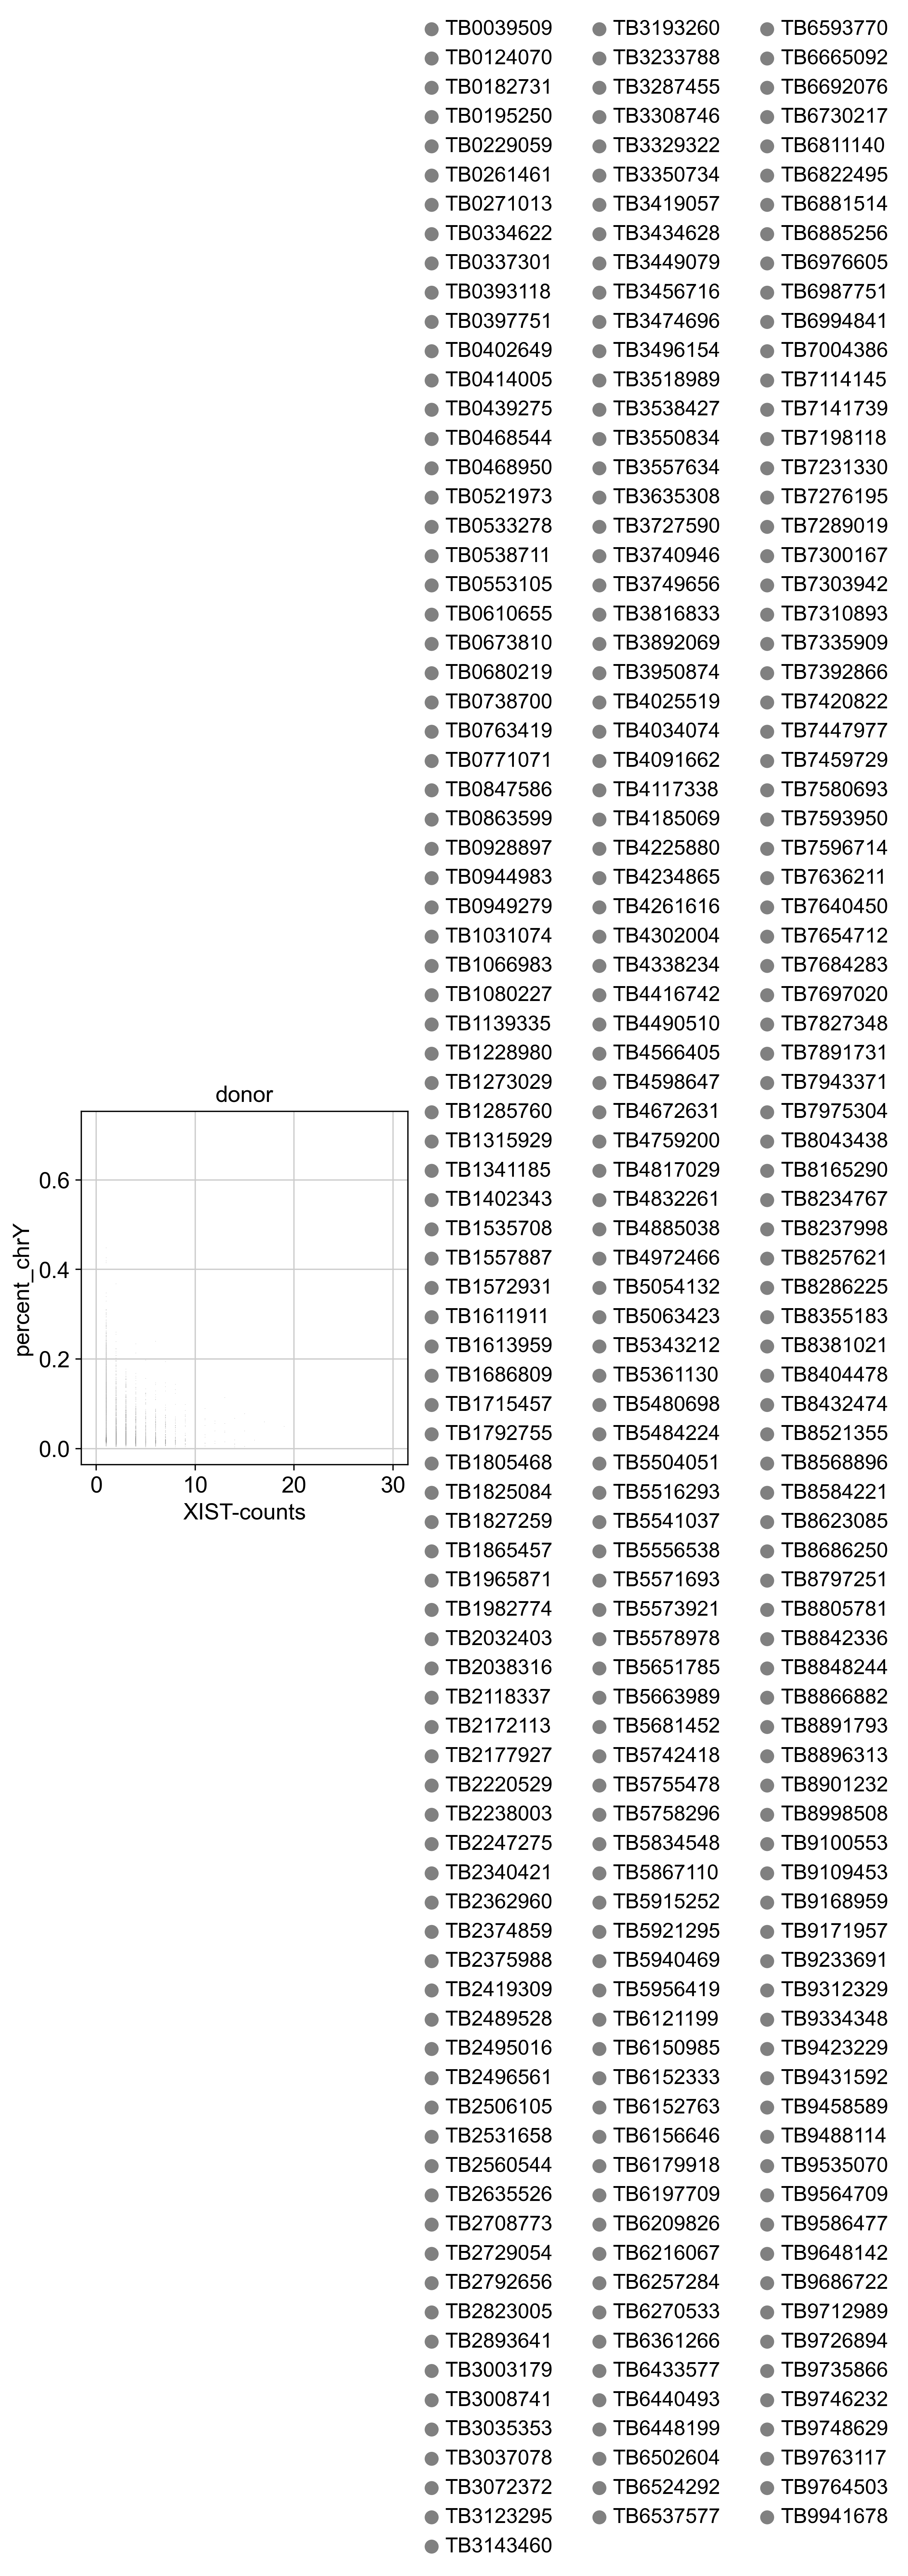

In [36]:
sample_object.obs["XIST-counts"] = sample_object.X[:,sample_object.var_names.str.match('XIST')].toarray()

sc.pl.scatter(sample_object, x = 'XIST-counts', y = 'percent_chrY', color = "donor")

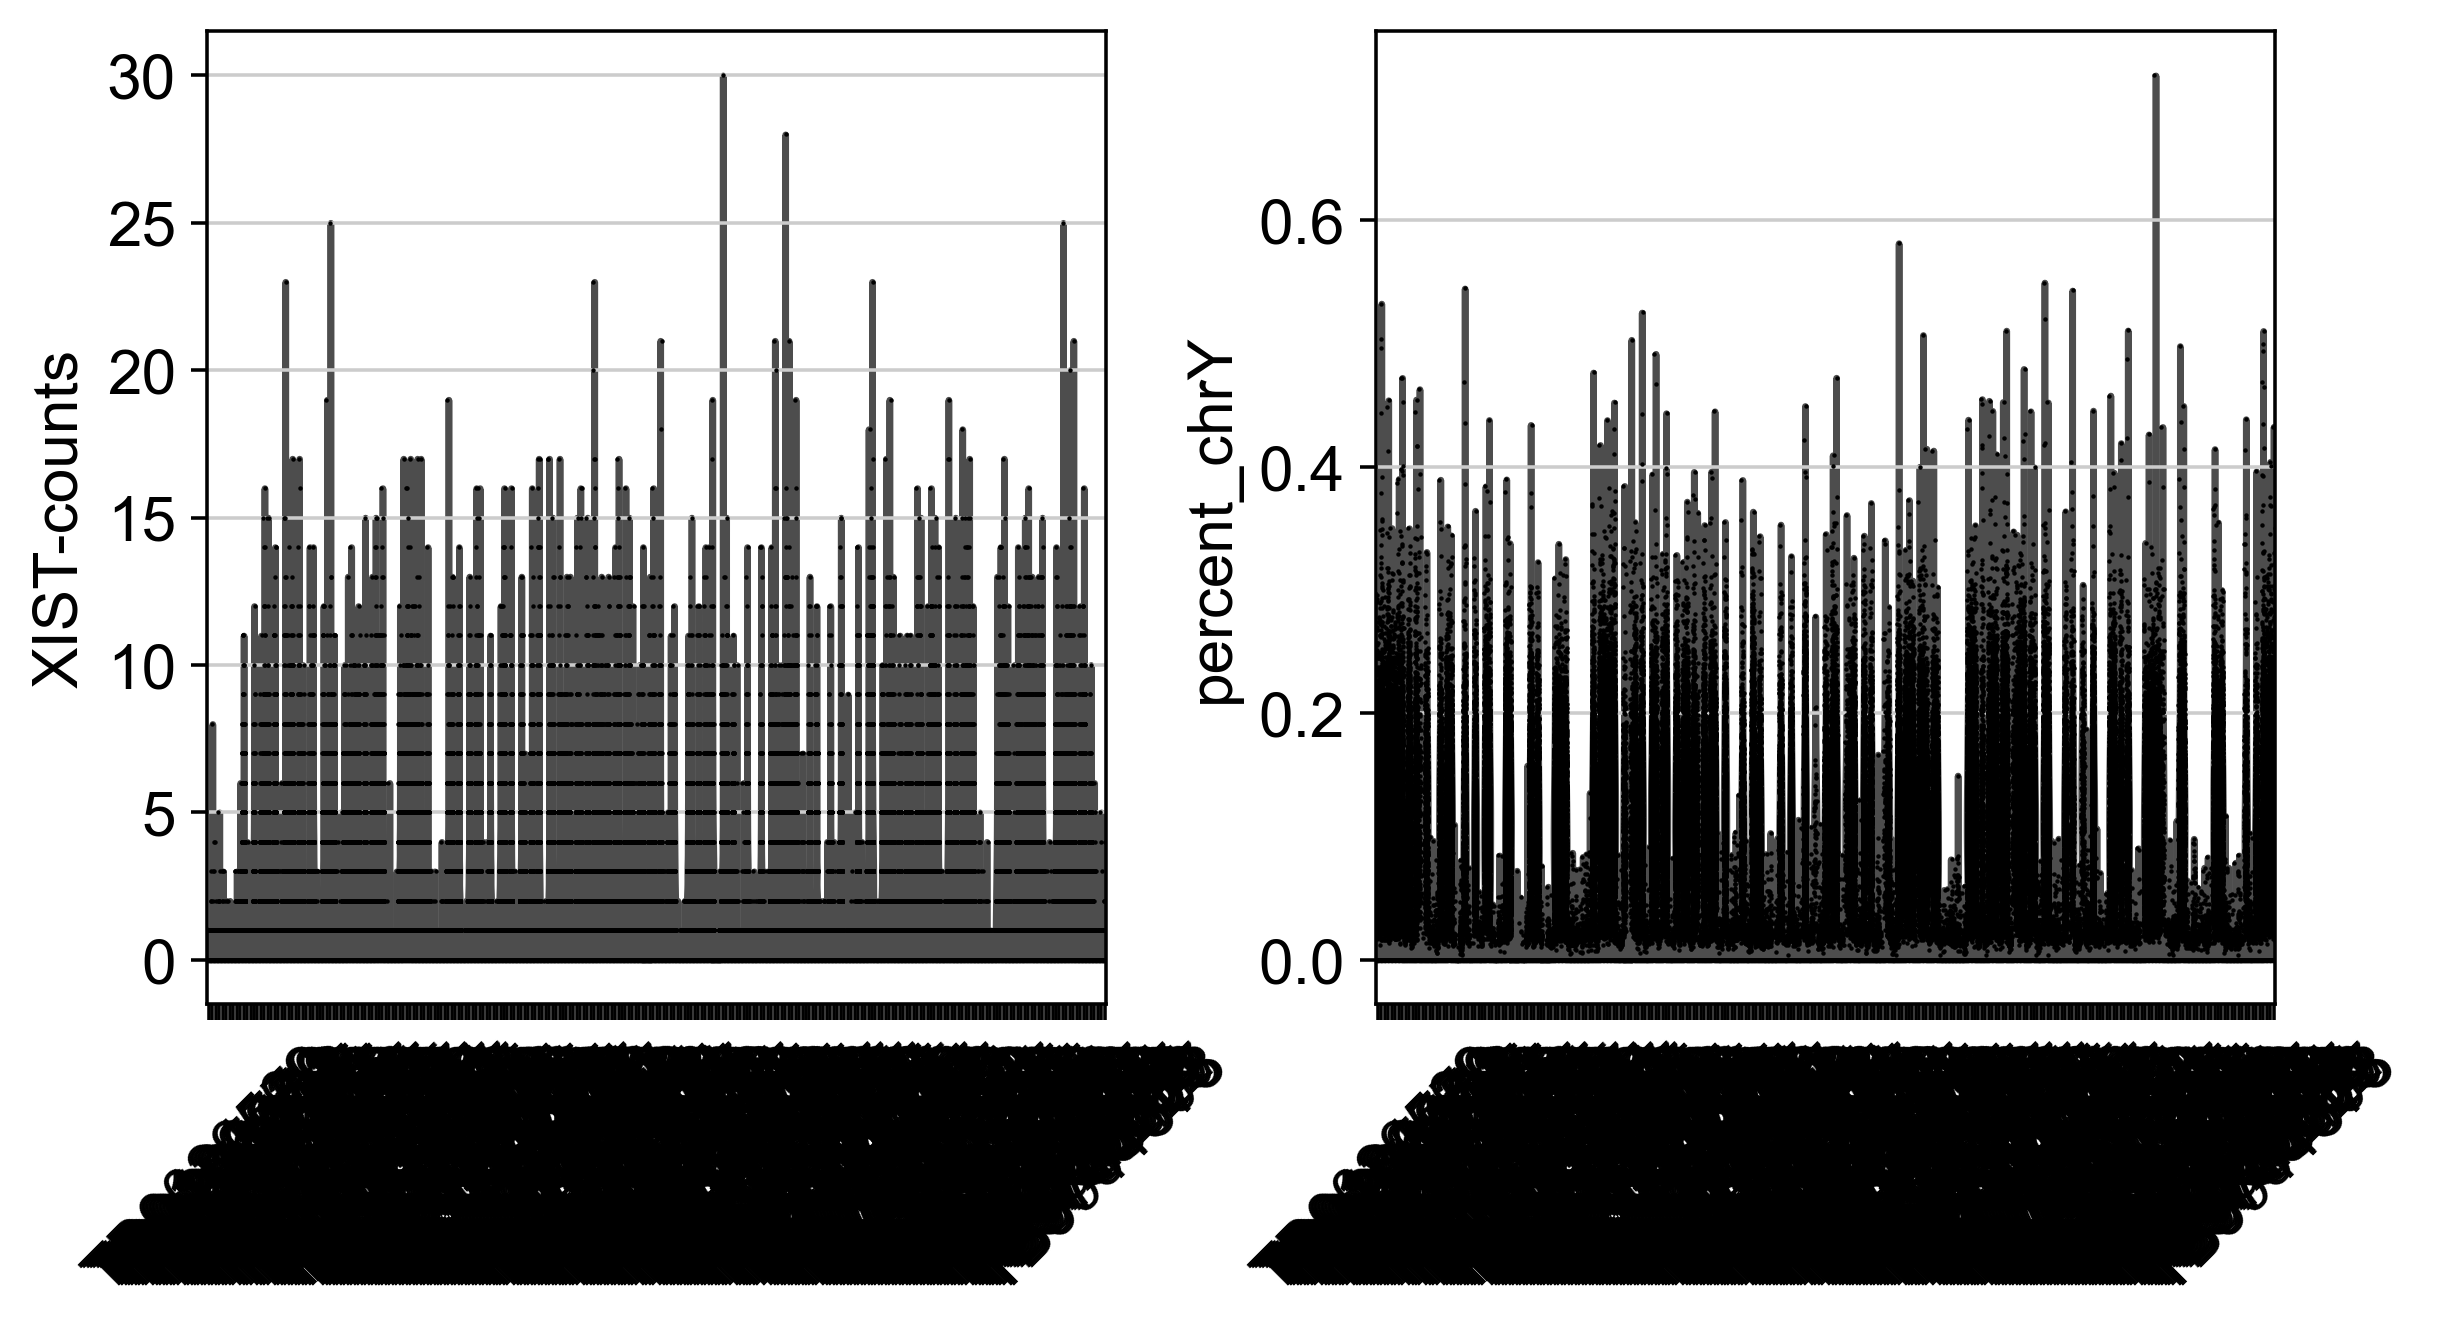

In [37]:
sc.pl.violin(sample_object, ["XIST-counts", "percent_chrY"], jitter = 0.4, groupby = 'donor', rotation = 45)

### Calculate cell cycle scores

In [40]:
!if [ ! -f /Users/mairi.mcclean/cell_cycle_gene.txt ]; then curl -o /Users/mairi.mcclean/cell_cycle_gene.txt https://raw.githubusercontent.com/theislab/scanpy_usage/master/180209_cell_cycle/data/regev_lab_cell_cycle_genes.txt; fi

In [41]:
cell_cycle_genes = [x.strip() for x in open('/Users/mairi.mcclean/cell_cycle_gene.txt')]
print(len(cell_cycle_genes))

# Split into 2 lists
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]

cell_cycle_genes = [x for x in cell_cycle_genes if x in sample_object.var_names]
print(len(cell_cycle_genes))

97
94


- Create basic `anndata` for score calculation

In [42]:
adata_log = anndata.AnnData(X = sample_object.X,  var = sample_object.var, obs = sample_object.obs)
sc.pp.normalize_total(adata_log, target_sum = 1e6, exclude_highly_expressed = True)
sc.pp.log1p(adata_log)

: 

: 

In [ ]:
sc.tl.score_genes_cell_cycle(adata_log, s_genes = s_genes, g2m_genes = g2m_genes)
sc.pl.violin(adata_log, ['S_score', 'G2M_score'],
             jitter = 0.4, groupby = 'donor', rotation = 45)

In [ ]:
sample_object.obs['S_score'] = adata_log.obs['S_score']
sample_object.obs['G2M_score'] = adata_log.obs['G2M_score']
sample_object

### Predict doublets

In [ ]:
scrub = scr.Scrublet(sample_object.X)
sample_object.obs['doublet_scores'], sample_object.obs['predicted_doublets'] = scrub.scrub_doublets()
scrub.plot_histogram()

sum(sample_object.obs['predicted_doublets'])

In [ ]:
sc.pl.violin(sample_object, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt','pct_counts_ribo', 'predicted_doublets'],
             jitter = 0.2, groupby = 'donor', rotation = 45)

In [ ]:
sc.pl.violin(sample_object, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt','pct_counts_ribo', 'predicted_doublets'],
             jitter = 0.2, groupby = 'sample', rotation = 45)

### Prepare counts for individual slots

In [ ]:
sample_object.raw = sample_object.copy()
sample_object.layers['counts'] = sample_object.X.copy()
sample_object.layers["sqrt_norm"] = np.sqrt(
    sc.pp.normalize_total(sample_object, inplace = False)["X"]
)
sample_object

### Export object

In [ ]:
sample_object.write('/Users/mairi.mcclean/github/data/tb_pbmc_datasets/Nathan2021_PBMC_TB_QCed_pre-process_mm221122.h5ad')
